1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
  - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
  - 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
  - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

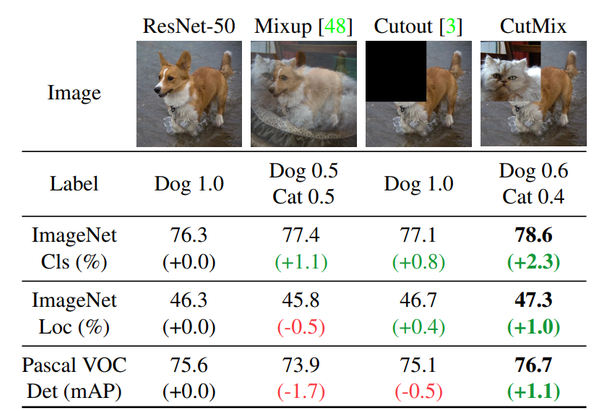

## 1. Augmentation을 적용한 데이터셋 만들기

### 1-1 데이터셋 가져오기

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIRL1V0/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIRL1V0/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


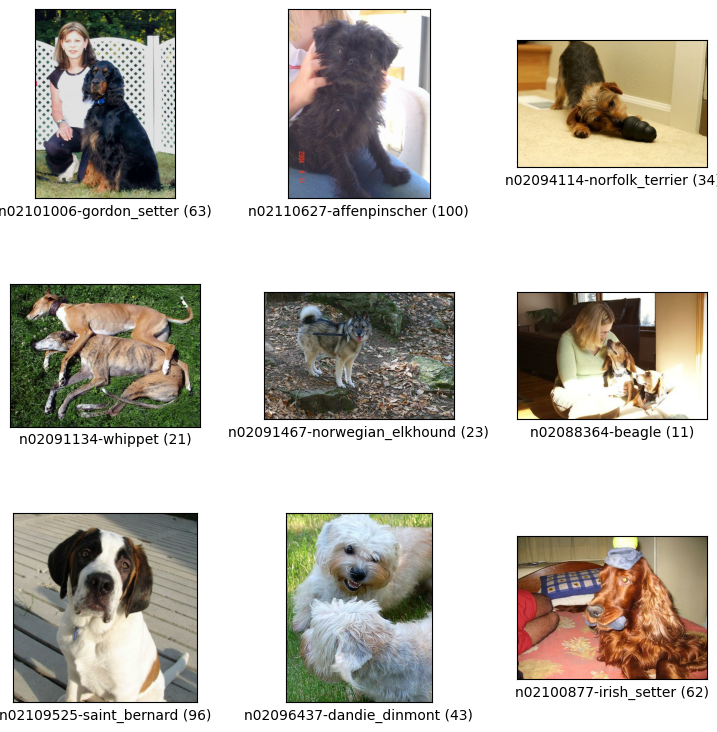

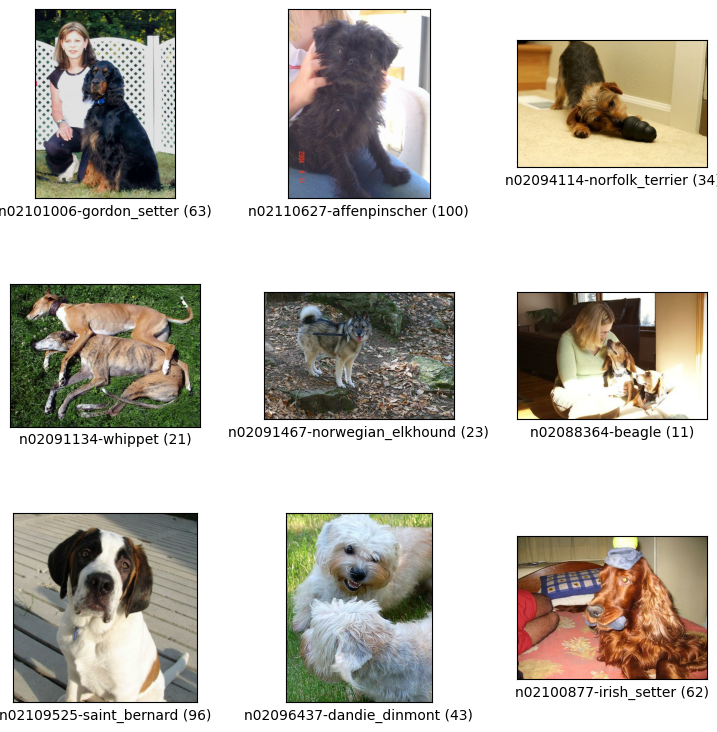

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

tfds.show_examples(ds_train, ds_info)

In [2]:
print(ds_info.features['label'].names) # 강아지 품종 데이터

['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshire_t

In [3]:
!pip install -U tensorflow-datasets

In [4]:
num_classes = ds_info.features["label"].num_classes

### 1-2 전처리 함수

### Cutmix

In [5]:
# cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * 0.8 * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * 0.8 * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=0.7, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
      if tf.random.uniform([]) < prob:
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_label = mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes)
      else:
        # CutMix 미적용
        mixed_img = image[i]
        mixed_label = label[i]
        if len(mixed_label.shape) == 0:
          mixed_label = tf.one_hot(mixed_label, num_classes)
      mixed_imgs.append(mixed_img)
      mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

In [7]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
      if tf.random.uniform([]) < prob:
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

      else:
        # CutMix 미적용
        mixed_img = image[i]
        mixed_label = label[i]
        if len(mixed_label.shape) == 0:
          mixed_label = tf.one_hot(mixed_label, num_classes)

      mixed_imgs.append(mixed_img)
      mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):

    ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
    )
    if not is_test and with_aug:
      ds = ds.map(
          augment
      )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
      ds = ds.map(
          cutmix,
          num_parallel_calls=2
      )
    elif not is_test and with_mixup:
      ds = ds.map(
          mixup,
          num_parallel_calls=2
      )
    else:
      ds = ds.map(
          onehot,
          num_parallel_calls=2
      )
    if not is_test:
      ds = ds.repeat()
      ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 1-3 전처리 적용 - No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용

In [9]:
# No Augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 기본 Augmentation
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# 기본 + CutMix 적용
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

# 기본 + Mixup 적용
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [10]:
import matplotlib.pyplot as plt

def show_data_images(ds, num):
    plt.figure(figsize=(num * 5, num * 5))

    for i, (images, labels) in enumerate(ds.take(num)):
        image_a = images[i]

        plt.subplot(num, 1, i + 1)
        plt.imshow(image_a)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()  # for 루프 외부에서 plt.show() 호출

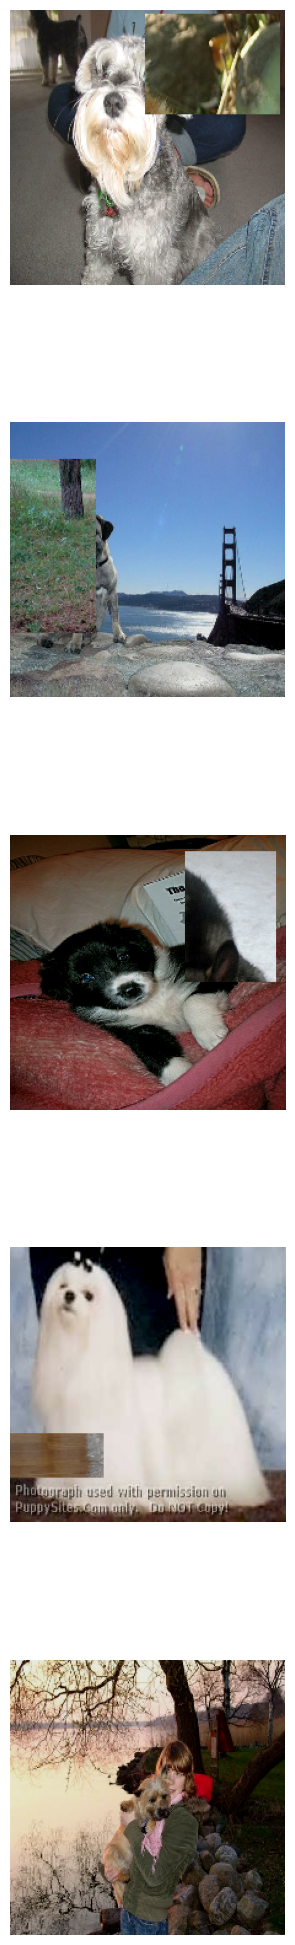

In [118]:
show_data_images(ds_train_cutmix, 5)

## 2. 모델 만들기 - ResNet50

## 3. 모델 훈련하기 - categorical_crossentropy() 사용

In [11]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

### 3-1 No Augmentation

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "model_checkpoint.ckpt1"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stop_callback]
)


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.1900 - accuracy: 0.4523
Epoch 1: val_loss improved from inf to 3.52292, saving model to model_checkpoint.ckpt1
750/750 [==============================] - 80s 77ms/step - loss: 2.1900 - accuracy: 0.4523 - val_loss: 3.5229 - val_accuracy: 0.1809
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.8125
Epoch 2: val_loss improved from 3.52292 to 1.04053, saving model to model_checkpoint.ckpt1
750/750 [==============================] - 56s 75ms/step - loss: 0.6976 - accuracy: 0.8125 - val_loss: 1.0405 - val_accuracy: 0.6923
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9390
Epoch 3: val_loss improved from 1.04053 to 0.97734, saving model to model_checkpoint.ckpt1
750/750 [==============================] - 57s 75ms/step - loss: 0.2754 - accuracy: 0.9390 - val_loss: 0.9773 - 

### 3-2 기본 Augmentation

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "model_checkpoint.ckpt2"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2799 - accuracy: 0.4311
Epoch 1: val_loss improved from inf to 2.80073, saving model to model_checkpoint.ckpt2
750/750 [==============================] - 72s 75ms/step - loss: 2.2799 - accuracy: 0.4311 - val_loss: 2.8007 - val_accuracy: 0.3024
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.7042
Epoch 2: val_loss improved from 2.80073 to 1.20075, saving model to model_checkpoint.ckpt2
750/750 [==============================] - 55s 74ms/step - loss: 1.0098 - accuracy: 0.7042 - val_loss: 1.2007 - val_accuracy: 0.6481
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.8366
Epoch 3: val_loss did not improve from 1.20075
750/750 [==============================] - 54s 72ms/step - loss: 0.5839 - accuracy: 0.8366 - val_loss: 1.3239 - val_accuracy: 0.6342
Epoch 4/20
750/750 [==============================] - ETA: 0s - loss: 0.3221 - accuracy:

### 3-3 기본 + CutMix 적용

In [13]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "model_checkpoint.ckpt3"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 3.2404 - accuracy: 0.3022
Epoch 1: val_loss improved from inf to 2.99081, saving model to model_checkpoint.ckpt3
750/750 [==============================] - 103s 105ms/step - loss: 3.2404 - accuracy: 0.3022 - val_loss: 2.9908 - val_accuracy: 0.2610
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 2.1956 - accuracy: 0.5537
Epoch 2: val_loss improved from 2.99081 to 1.26406, saving model to model_checkpoint.ckpt3
750/750 [==============================] - 72s 96ms/step - loss: 2.1956 - accuracy: 0.5537 - val_loss: 1.2641 - val_accuracy: 0.6344
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 1.8796 - accuracy: 0.6515
Epoch 3: val_loss did not improve from 1.26406
750/750 [==============================] - 76s 102ms/step - loss: 1.8796 - accuracy: 0.6515 - val_loss: 2.2469 - val_accuracy: 0.4377
Epoch 4/20
750/750 [==============================] - ETA: 0s - loss: 1.6783 - accura

In [16]:
aug_cutmix_resnet50_chk = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_cutmix_resnet50_chk.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "model_checkpoint.ckpt3"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

aug_cutmix_resnet50_chk.load_weights(checkpoint_path)

history_resnet50_aug_cutmix = aug_cutmix_resnet50_chk.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 1.3616 - accuracy: 0.8347
Epoch 1: val_loss improved from inf to 1.10980, saving model to model_checkpoint.ckpt3
750/750 [==============================] - 126s 103ms/step - loss: 1.3616 - accuracy: 0.8347 - val_loss: 1.1098 - val_accuracy: 0.6931
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 1.3017 - accuracy: 0.8547
Epoch 2: val_loss improved from 1.10980 to 1.10478, saving model to model_checkpoint.ckpt3
750/750 [==============================] - 78s 104ms/step - loss: 1.3017 - accuracy: 0.8547 - val_loss: 1.1048 - val_accuracy: 0.6959
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 1.2578 - accuracy: 0.8612
Epoch 3: val_loss improved from 1.10478 to 1.05978, saving model to model_checkpoint.ckpt3
750/750 [==============================] - 73s 97ms/step - loss: 1.2578 - accuracy: 0.8612 - val_loss: 1.0598 - val_accuracy: 0.7108
Epoch 4/20
750/750 [=====================

### 기본 + Mixup 적용

In [ ]:
aug_mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "model_checkpoint.ckpt4"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_resnet50_aug_mixup = aug_mix_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.7702 - accuracy: 0.3586
Epoch 1: val_loss improved from inf to 3.63982, saving model to model_checkpoint.ckpt4
750/750 [==============================] - 76s 78ms/step - loss: 2.7702 - accuracy: 0.3586 - val_loss: 3.6398 - val_accuracy: 0.1746
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.6158
Epoch 2: val_loss improved from 3.63982 to 1.49066, saving model to model_checkpoint.ckpt4
750/750 [==============================] - 58s 77ms/step - loss: 1.6712 - accuracy: 0.6158 - val_loss: 1.4907 - val_accuracy: 0.5807
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 1.3287 - accuracy: 0.7245
Epoch 3: val_loss improved from 1.49066 to 1.16064, saving model to model_checkpoint.ckpt4
750/750 [==============================] - 58s 77ms/step - loss: 1.3287 - accuracy: 0.7245 - val_loss: 1.1606 - val_accuracy: 0.6719
Epoch 4/20
750/750 [========================

## 4. 훈련 과정 시각화하기

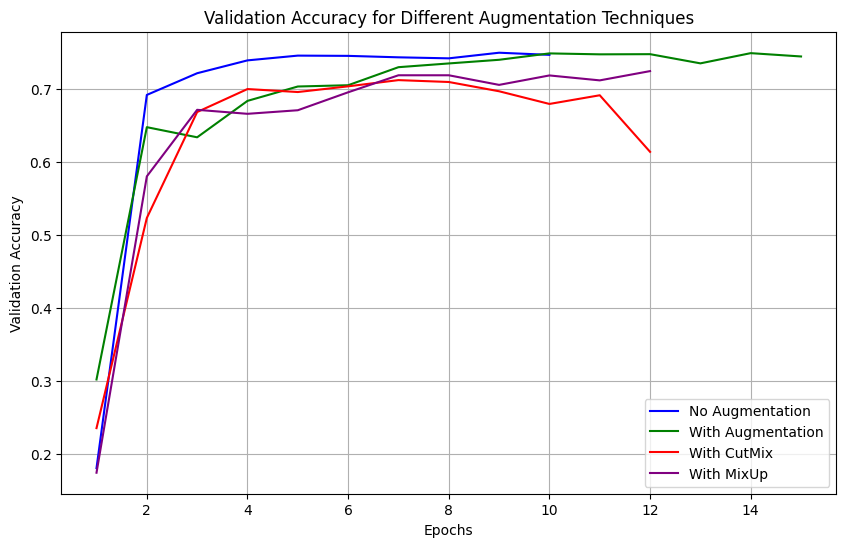

In [ ]:
import matplotlib.pyplot as plt

# 네 가지 모델의 history 데이터
histories = [history_resnet50_no_aug, history_resnet50_aug, history_resnet50_aug_cutmix, history_resnet50_aug_mixup]
labels = ['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp']
colors = ['blue', 'green', 'red', 'purple']

# 그래프 생성 및 설정
plt.figure(figsize=(10, 6))

for i, history in enumerate(histories):
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(val_accuracy) + 1)
    plt.plot(epochs, val_accuracy, label=labels[i], color=colors[i])

plt.title('Validation Accuracy for Different Augmentation Techniques')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## 5. Augmentation에 의한 모델 성능 비교

## 6. 실험

### cutmix prob 0.7 + 자르는 이미지 0.7 비율

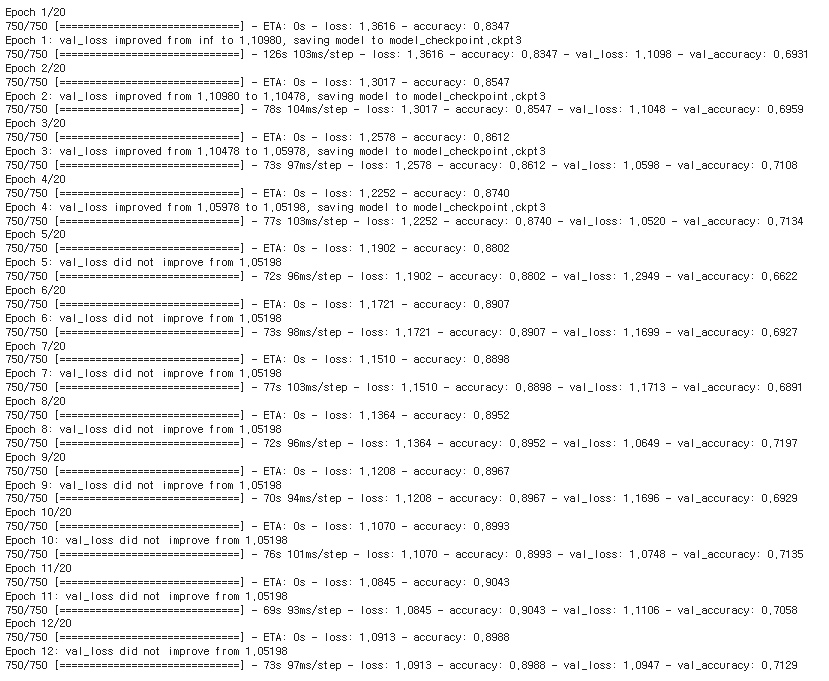

### cutmix prob 0.5

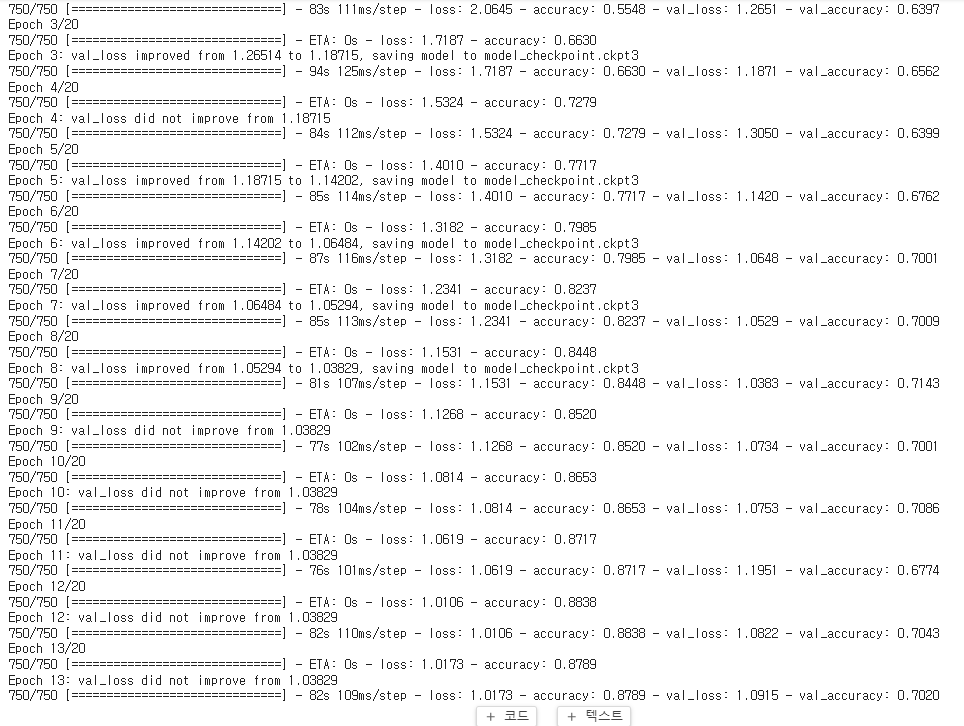

### cutmix prob 0.3

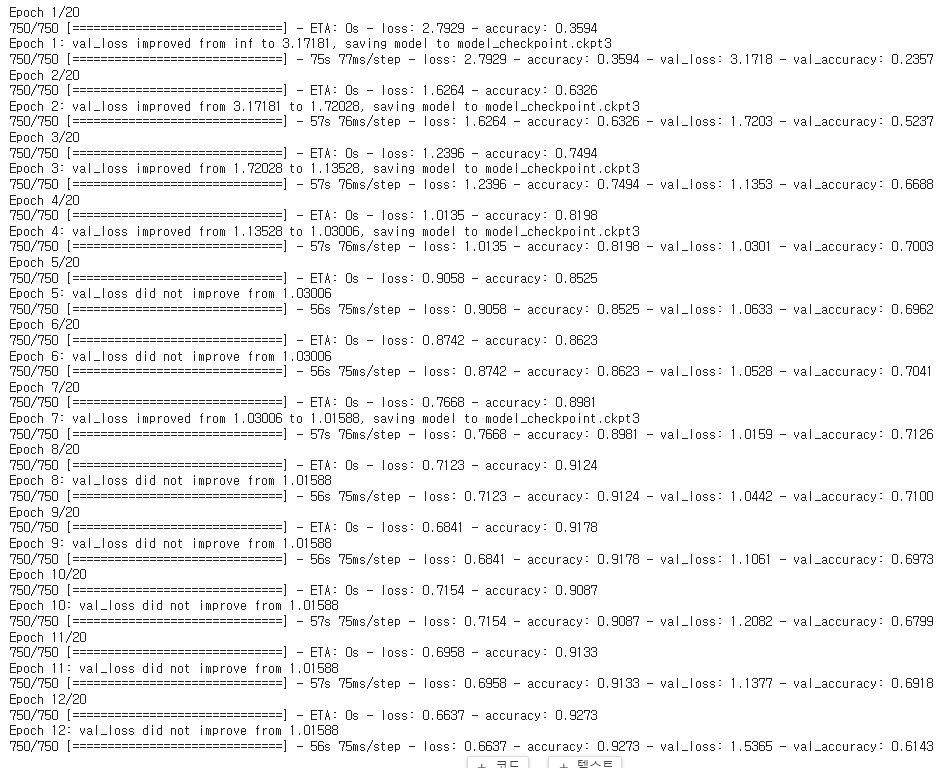

### mixup prob 0.5

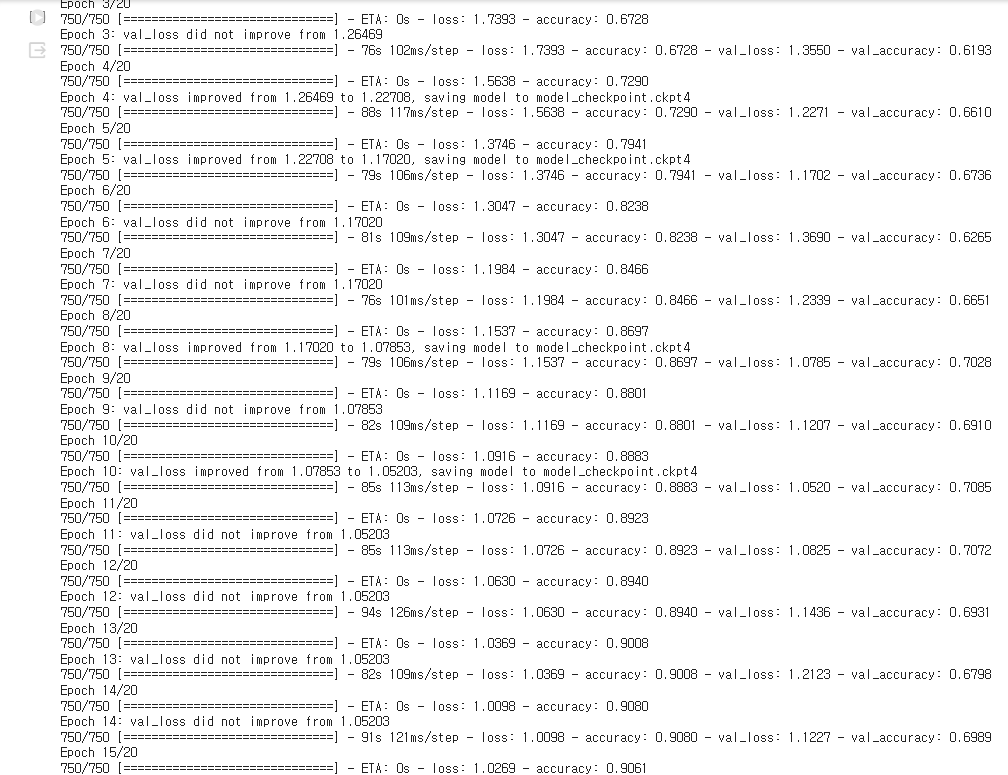

### mixup prob 0.3

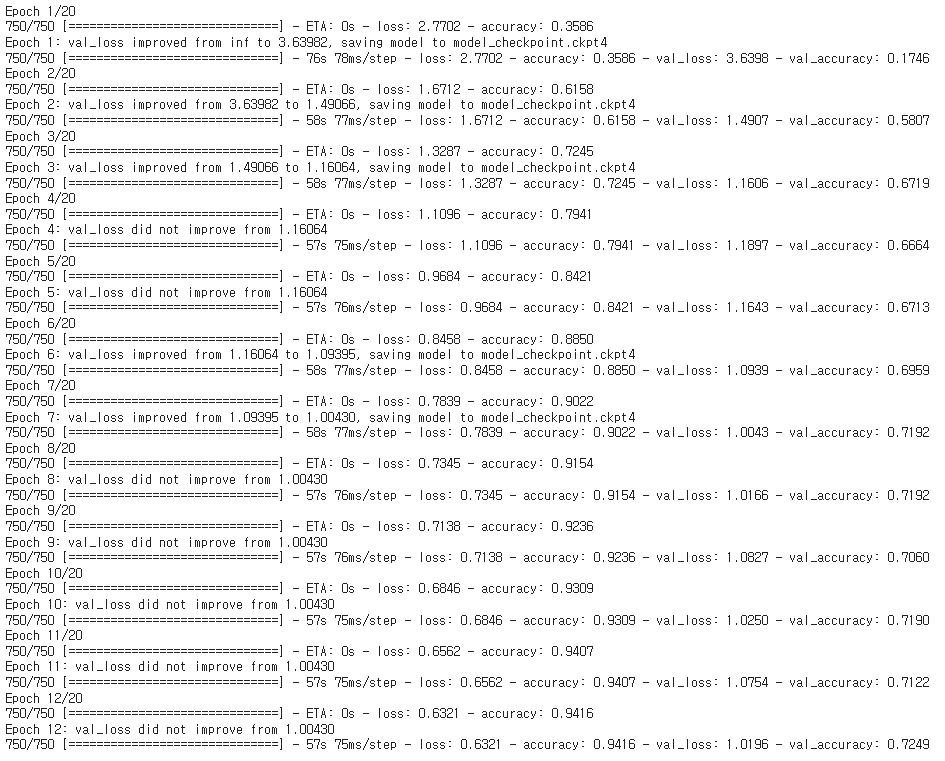

## 7. 결과

1. 결과는 그래프를 볼 수 있듯이 기본 aug의 경우가 가장 높게 나왔다.

그 이류를 알아보기 위해서 cutmix 처리 된 이미지를 출력해서 여러변 확인을 해봤는데 배경이 잘려서 강아지를 가린다거나 그런 문제가 많아서 원본 이미지가 훼손이 된 것 같아서 그런 것 같다..

그래서 시도해본 방법으로는 cut을 하는 이미지의 최대 크기에 0.7 배율을 반영해서 잘라오는 이미지가 원본 이미지에 큰 영향을 주지 못하게 만들어 보았다.

두 번째 시도해본 방법은 prob으로 0.3 0.5 0.7비율로 돌려봤는데 그래도 최고점은 0.7 비율에 배율 0.7로 조정한 부분이 0.7197로 val_accuracy가 가장 높았다.. (물론 cutmix중)

2. 학습 시간이 오래걸려서 옵티마이저 변경 시도를 해보았다.  

대부분의 경우에 adam이 더 좋은 학습 결과를 가져오는 것으로 알고 있어서 실험해 봤는데 Nadam도 포함해서 더 학습 결과가 안좋았다.

https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py#L279 cutmix 깃헙을 들어가 보았는데 여기서 resnet50에 sgd lr 0.01을 사용하고 있었는데 이유가 있었나보다. momentum이 잘 어울리지 않는 것일까..?

3. cutmix가 제대로 적용되려면?

cutmix가 제대로 적용시키려면 잘라오는 사진도 의미가 어느정도 있어야 할 것 같고(풀과 같은 배경이 잘려오는 경우가 많았다.) 그 잘라온 사진이 원본 이미지의 강아지를 가리는 일(원본 이미지 훼손으로 정보 가치 하락?)이 적어지도록 하는 방법을 찾아야 할 것 같다..

결론은 서로 라벨이 섞여서 비율을 나누는데 그 값어치를 하지 못하게 되는 데이터가 될 수도 있는 것 같다..

근데 이제 생각해본 결과는 논문에 나오는 깃헙의 cutmix모델은 prob이 1.0으로 전부 (imagenet가중치를 pre_train된 데이터에) cutmix화 시켜서 추가 학습을 하는 것이라서.. 일반화가 어느정도 된 모델에 추가로 강건성을 추가해주는 느낌이라 더 잘 학습이 된 게 아닐까 하는... 기존에 어느정도 학습된 모델에 증강이 제대로 추가한 느낌..?

아래는 https://github.com/clovaai/CutMix-PyTorch/blob/master/README.md
경로에 나와있는 파라미터 값이다.
-----
python train.py \
--net_type resnet \
--dataset imagenet \
--batch_size 256 \
--lr 0.1 \
--depth 50 \
--epochs 300 \
--expname ResNet50 \
-j 40 \
--beta 1.0 \
--cutmix_prob 1.0 \
--no-verbos

-----

## 8. 회고

이번 실험을 하면서 기본적인 augmentation은 중요하구나라고 느꼈지만 모델과 데이터의 양등 다른 조건을 비교해 보면서 처리를 해줘야 한다는 것을 좀 깊게? 이해한 것 같다.
기회가 된다면 cutmix github에 있는 pre_trained 모델을 다운로드해서 확인을 해봐야겠다..

아쉬운 점은 실험을 너무 많이 해버려서 내 코랩 컴퓨팅 단위가 녹았다. . . .
핳하 ㅎ ㅏ ...